In [2]:
import sys
import os
__file__ = %pwd
def parent_dir(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path
sys.path.append(parent_dir(__file__, 1))
from __init__ import *

HOME_LOC: /Project/Project/KDD2024/v0.4


In [3]:
# from MACNN_attack_VAE import AdversarialModel
loc = "/Project/Project/KDD2024/v0.4/OUTPUT/train/model=Classifier_MACNN_defence=None"

loc1 = "/Project/Project/KDD2024/v0.4/DATA"

data = UNIVARIATE_DATASET_NAMES[0]
train_data_path = f"{loc1}/UCRArchive_2018/{data}/{data}_TRAIN.tsv"
test_data_path = f"{loc1}/UCRArchive_2018/{data}/{data}_TEST.tsv"

from sklearn.preprocessing import LabelEncoder

train_data = np.loadtxt(train_data_path)
x_train = train_data[:, 1:]  # 去掉第一列
y_train = train_data[:, 0]

test_data = np.loadtxt(test_data_path)
x_test = test_data[:, 1:]  # 去掉第一列
y_test = test_data[:, 0]

# 使用 LabelEncoder 对标签进行编码
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

seq_len = x_train.shape[1]
unique_classes = len(np.unique(y_train))
# Assuming y_train is a numpy array containing your class labels


# __________________

# Z norm, x = [30, 470], 对30个样本单独做z norm， 分别求30个std和mean，对470做norm

x_train_mean = x_train.mean(axis=1, keepdims=True)
x_train_std = x_train.std(axis=1, keepdims=True)
x_train_norm = (x_train - x_train_mean) / (x_train_std + 1e-8)

x_test_mean = x_test.mean(axis=1, keepdims=True)
x_test_std = x_test.std(axis=1, keepdims=True)
x_test_norm = (x_test - x_test_mean) / (x_test_std + 1e-8)

# __________________


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# __________________
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# __________________


# Convert numpy arrays to PyTorch tensorsz
x_train_tensor = torch.tensor(x_train_norm, dtype=torch.float).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
x_train_tensor.shape

torch.Size([100, 1, 1460])

In [5]:
from CODE.Train.macnn import *

model = Classifier_MACNN(x_train_tensor.shape, unique_classes).to(device)
check_point = torch.load(
    f"/Project/Project/KDD2024/v0.4/OUTPUT/train/model=Classifier_MACNN_defence=None/{data}/MODEL_INFO.pth"
)

In [6]:
check_point.keys()

dict_keys(['architecture', 'epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'config', 'adeversarial_training', 'out_dir'])

In [7]:
model.load_state_dict(check_point["model_state_dict"])

<All keys matched successfully>

In [8]:
unique_classes

10

In [9]:
def calculate_jacob(model, x, unique_classes):
    # # 创建一个输入张量
    # x = x_test_tensor.to(device).requires_grad_(True)
    # model = model.to(device)

    # 假设您的模型输出是形状为 [30, 5] 的 logits
    outputs = model(x)

    # 初始化一个用于保存 Jacobian 的张量
    jacobians = torch.zeros(unique_classes, *x.shape).to(device)

    # 为每个输出类别计算梯度
    for i in range(unique_classes):
        # 选择第 i 个类别的输出
        class_output = outputs[:, i]

        # 计算每个样本对该类别输出的梯度
        grads = torch.autograd.grad(
            class_output,
            x,
            grad_outputs=torch.ones_like(class_output),
            create_graph=True,
        )[0]

        # 保存梯度
        jacobians[i] = grads

    # 调整 Jacobian 的形状以匹配您的需求
    jacobians = jacobians.transpose(0, 1)
    return jacobians


def select_label(tensor_, labels):
    sample_indices = torch.arange(0, tensor_.shape[0], device=tensor_.device)

    selected_ = tensor_[sample_indices, labels]
    return selected_

In [11]:
model.eval()
epoch = 1000
x_adv = []
y_adv = []

for x_test_tensor, _ in test_loader:

    samples = x_test_tensor.to(device)
    labels = model(samples).argmax(-1)
    batch_size = len(samples)

    r = torch.zeros_like(samples)
    overshoot = 0.01
    samples.requires_grad = True
    # r_ = torch.zeros_like(samples)
    attack_success = torch.zeros(batch_size, dtype=torch.bool, device=device)
    for i in range(epoch):
        fs = model(samples + r)

        _, pre = torch.max(fs, dim=-1)
        attack_success |= pre != labels
        if attack_success.all():
            break

        # criteria = (pre != labels).reshape(-1,1,1)
        # r_ = r*criteria*(~r_.bool()) + r_

        ws = calculate_jacob(model, samples + r, unique_classes)
        ws = ws * (~attack_success).unsqueeze(1).unsqueeze(2).unsqueeze(3)

        f_0 = select_label(fs, labels)
        w_0 = select_label(ws, labels)

        f = fs - f_0.unsqueeze(1)
        w = ws - w_0.unsqueeze(1)

        value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
        value = torch.where(
            torch.isnan(value), torch.tensor(float("inf"), device=value.device), value
        )

        _, hat_L = torch.min(value, -1)

        delta = (
            torch.abs(select_label(f, hat_L).reshape(-1, 1, 1))
            * select_label(w, hat_L)
            / (torch.norm(select_label(w, hat_L), p=2) ** 2)
        )
        r = torch.where(
            attack_success.unsqueeze(1).unsqueeze(2), r, r + (1 + overshoot) * delta
        )

        # r = r + (1 + overshoot) * delta * 10
        # r = r.detach()
        r = torch.clamp(r, min=-0.1, max=0.1).detach()

    # r_ = r*(~r_.bool()) + r_

    x_adv.append((samples + r).detach().cpu().numpy())
    # y_adv.append((torch.max(model(samples+r), dim=-1)[-1]).detach().cpu().numpy())
    y_adv.append(pre.detach().cpu().numpy())

x_adv = np.concatenate(x_adv, axis=0)
y_adv = np.concatenate(y_adv, axis=0)

y = y_test
print("ASR:", sum(y_adv != y) / 30)

x = samples.detach().cpu().numpy()
r = r.detach().cpu().numpy()
print("Dist:", (r**2).sum(-1).mean())

KeyboardInterrupt: 

In [ ]:
model.eval()
epoch = 1000
x_adv = []
y_adv = []

for x_test_tensor, _ in test_loader:

    samples = x_test_tensor.to(device)
    labels = model(samples).argmax(-1)
    batch_size = len(samples)

    r = torch.zeros_like(samples)
    overshoot = 0.01
    samples.requires_grad = True
    # r_ = torch.zeros_like(samples)
    attack_success = torch.zeros(batch_size, dtype=torch.bool, device=device)
    for i in range(epoch):
        fs = model(samples + r)

        _, pre = torch.max(fs, dim=-1)
        attack_success |= pre != labels
        if attack_success.all():
            break

        # criteria = (pre != labels).reshape(-1,1,1)
        # r_ = r*criteria*(~r_.bool()) + r_

        ws = calculate_jacob(model, samples + r, unique_classes)
        ws = ws * (~attack_success).unsqueeze(1).unsqueeze(2).unsqueeze(3)

        f_0 = select_label(fs, labels)
        w_0 = select_label(ws, labels)

        f = fs - f_0.unsqueeze(1)
        w = ws - w_0.unsqueeze(1)

        value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
        value = torch.where(
            torch.isnan(value), torch.tensor(float("inf"), device=value.device), value
        )
        if i == 0:
            _, indices = torch.topk(fs, k=2, dim=-1)  # 获取每行最大的两个值的索引
            hat_L = indices[:, 1]  # 第二大值的索引
            # _, hat_L = torch.min(f, -1)

        delta = (
            torch.abs(select_label(f, hat_L).reshape(-1, 1, 1))
            * select_label(w, hat_L)
            / (torch.norm(select_label(w, hat_L), p=2) ** 2)
        )
        r = torch.where(
            attack_success.unsqueeze(1).unsqueeze(2),
            r,
            r + (1 + overshoot) * delta * 1e8,
        )

        # r = r + (1 + overshoot) * delta * 10
        # r = r.detach()
        r = torch.clamp(r, min=-0.1, max=0.1).detach()

    # r_ = r*(~r_.bool()) + r_

    x_adv.append((samples + r).detach().cpu().numpy())
    # y_adv.append((torch.max(model(samples+r), dim=-1)[-1]).detach().cpu().numpy())
    y_adv.append(pre.detach().cpu().numpy())

x_adv = np.concatenate(x_adv, axis=0)
y_adv = np.concatenate(y_adv, axis=0)

y = y_test
print("ASR:", sum(y_adv != y) / 30)

x = samples.detach().cpu().numpy()
r = r.detach().cpu().numpy()
print("Dist:", (r**2).sum(-1).mean())

ASR: 0.9333333333333333
Dist: 4.609507


In [ ]:
model.eval()
epoch = 1000
x_adv = []
y_adv = []

for x_test_tensor, _ in test_loader:

    samples = x_test_tensor.to(device)
    labels = model(samples).argmax(-1)
    batch_size = len(samples)

    r = torch.zeros_like(samples)
    overshoot = 0.01
    samples.requires_grad = True
    # r_ = torch.zeros_like(samples)
    attack_success = torch.zeros(batch_size, dtype=torch.bool, device=device)
    for i in range(epoch):
        fs = model(samples + r)

        _, pre = torch.max(fs, dim=-1)
        attack_success |= pre != labels
        if attack_success.all():
            break

        # criteria = (pre != labels).reshape(-1,1,1)
        # r_ = r*criteria*(~r_.bool()) + r_

        ws = calculate_jacob(model, samples + r, unique_classes)
        ws = ws * (~attack_success).unsqueeze(1).unsqueeze(2).unsqueeze(3)

        f_0 = select_label(fs, labels)
        w_0 = select_label(ws, labels)

        f = fs - f_0.unsqueeze(1)
        w = ws - w_0.unsqueeze(1)

        value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
        value = torch.where(
            torch.isnan(value), torch.tensor(float("inf"), device=value.device), value
        )
        if i == 0:
            _, hat_L = torch.min(value, -1)

        delta = (
            torch.abs(select_label(f, hat_L).reshape(-1, 1, 1))
            * select_label(w, hat_L)
            / (torch.norm(select_label(w, hat_L), p=2) ** 2)
        )
        r = torch.where(
            attack_success.unsqueeze(1).unsqueeze(2),
            r,
            r + (1 + overshoot) * delta * 1e8,
        )

        # r = r + (1 + overshoot) * delta * 10
        # r = r.detach()
        r = torch.clamp(r, min=-0.1, max=0.1).detach()

    # r_ = r*(~r_.bool()) + r_

    x_adv.append((samples + r).detach().cpu().numpy())
    # y_adv.append((torch.max(model(samples+r), dim=-1)[-1]).detach().cpu().numpy())
    y_adv.append(pre.detach().cpu().numpy())

x_adv = np.concatenate(x_adv, axis=0)
y_adv = np.concatenate(y_adv, axis=0)

y = y_test
print("ASR:", sum(y_adv != y) / 30)

x = samples.detach().cpu().numpy()
r = r.detach().cpu().numpy()
print("Dist:", (r**2).sum(-1).mean())

ASR: 0.9333333333333333
Dist: 4.609507


In [ ]:
np.save("r_df.npy", r)

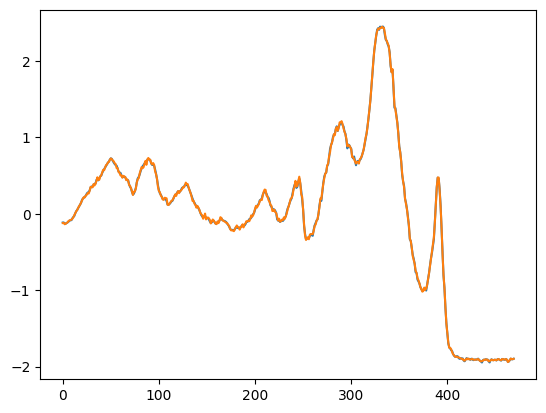

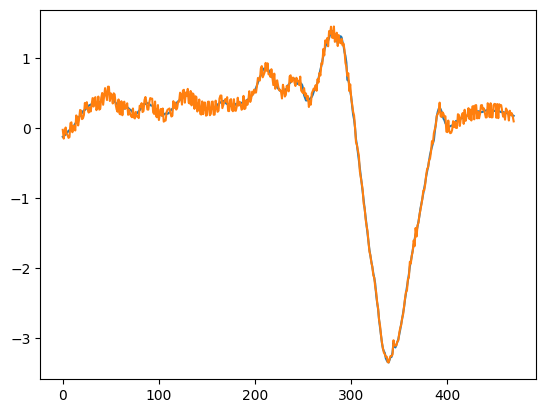

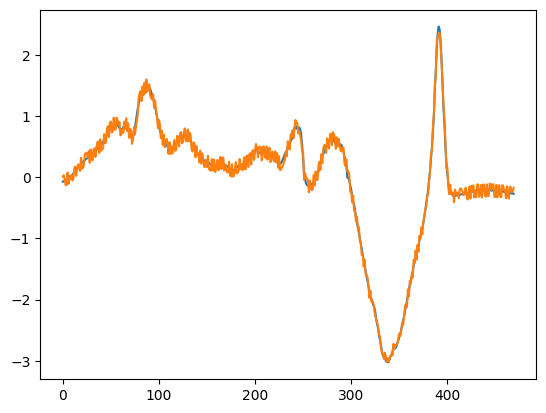

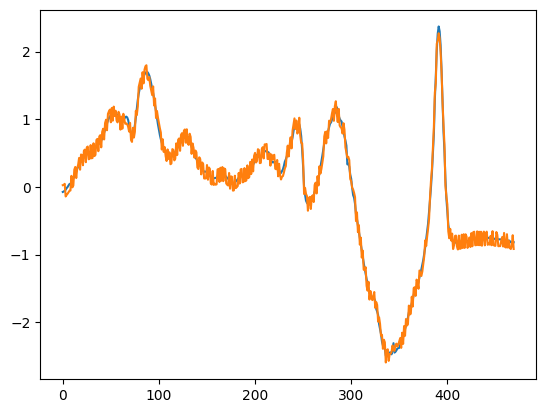

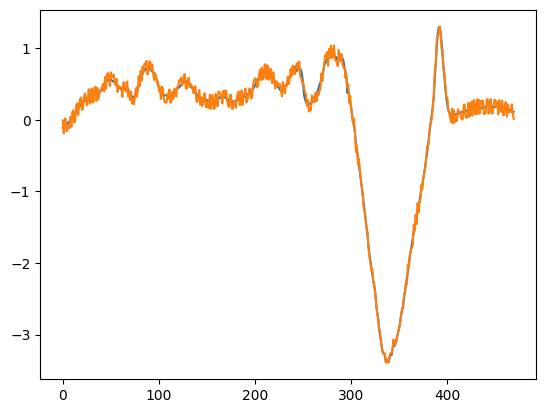

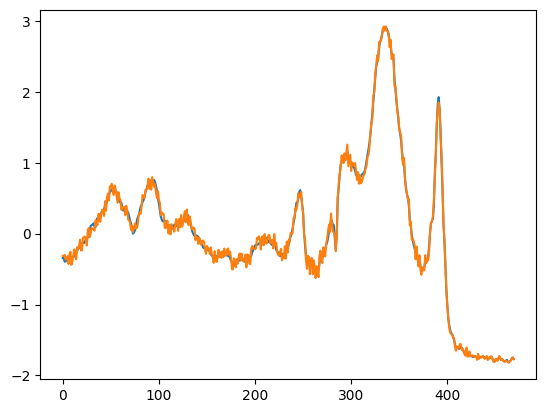

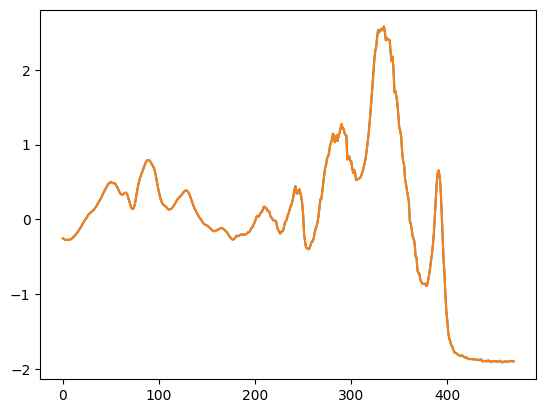

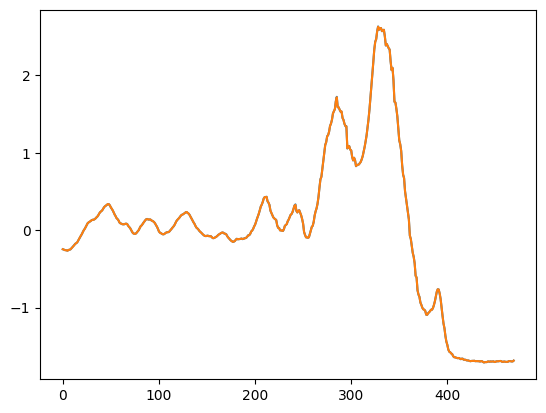

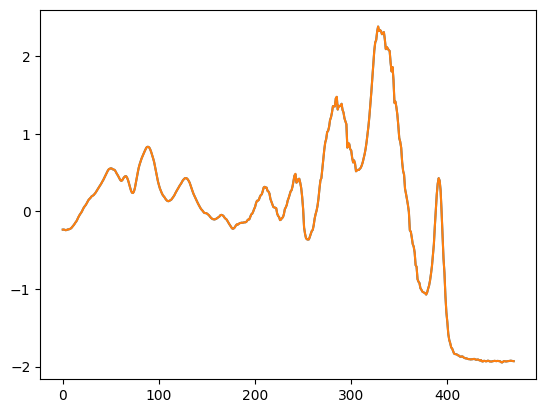

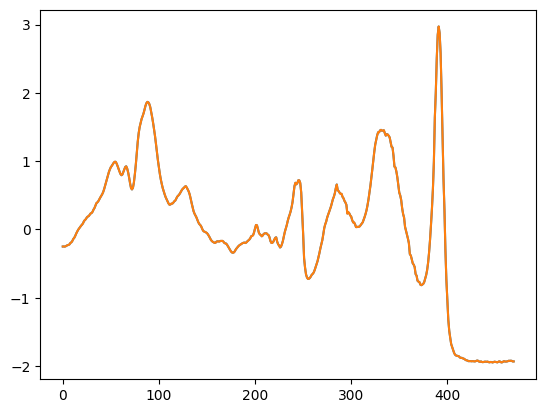

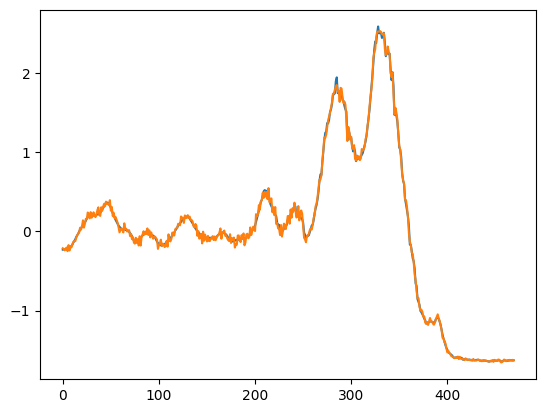

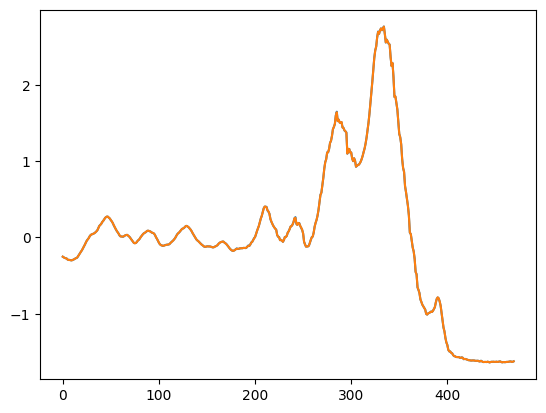

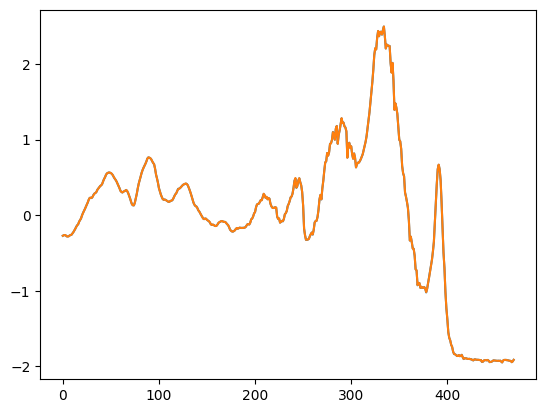

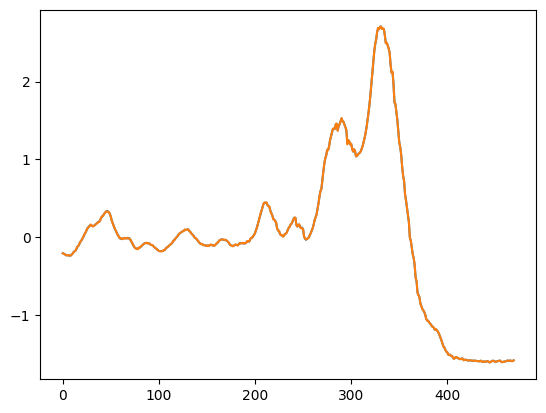

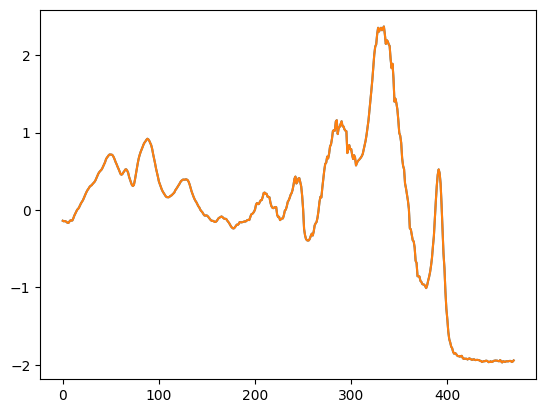

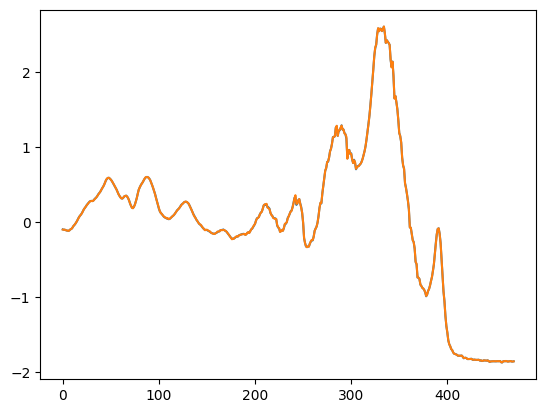

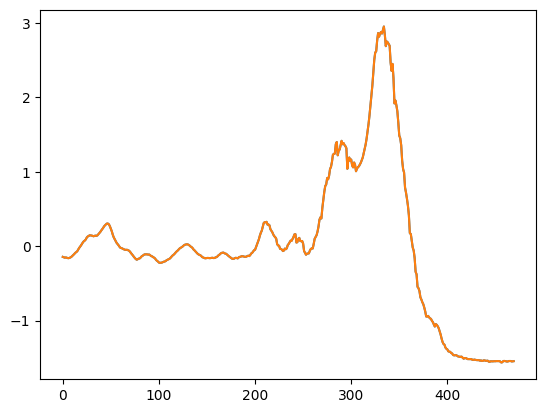

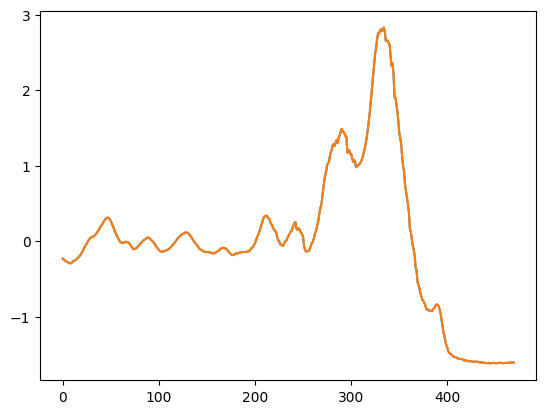

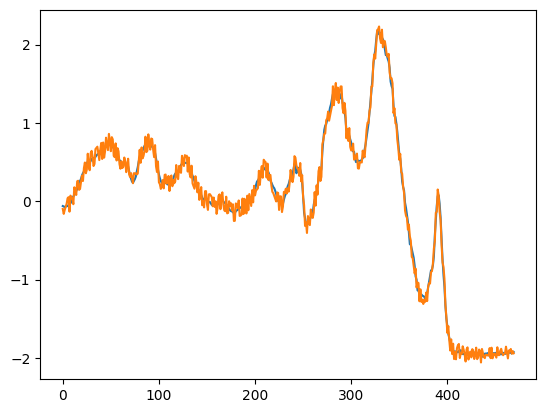

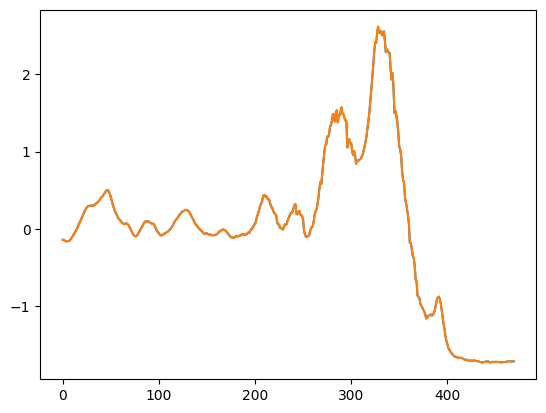

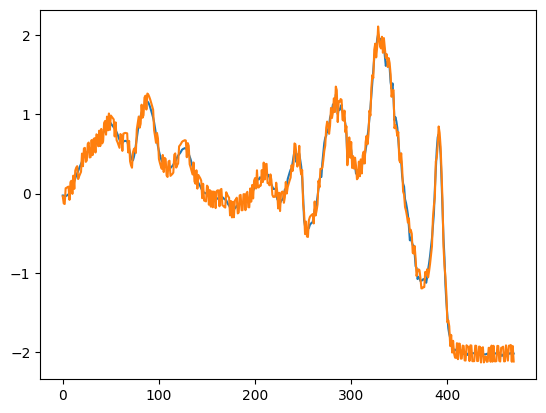

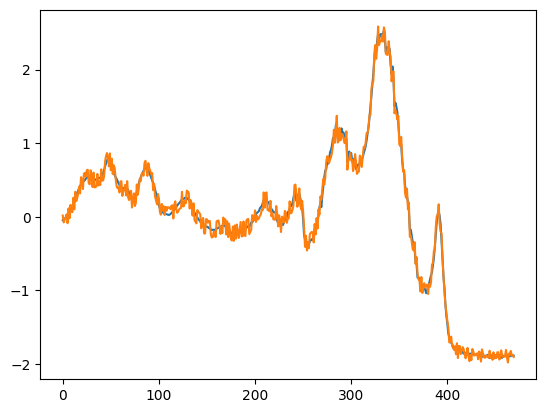

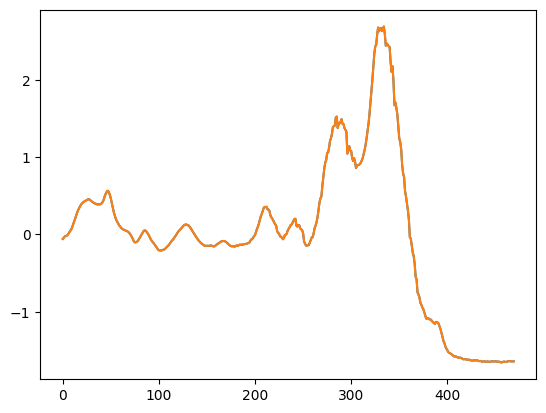

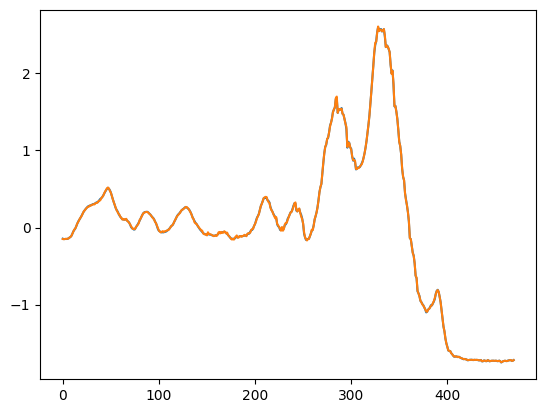

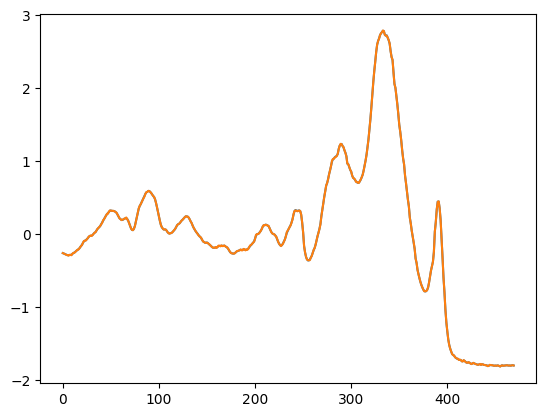

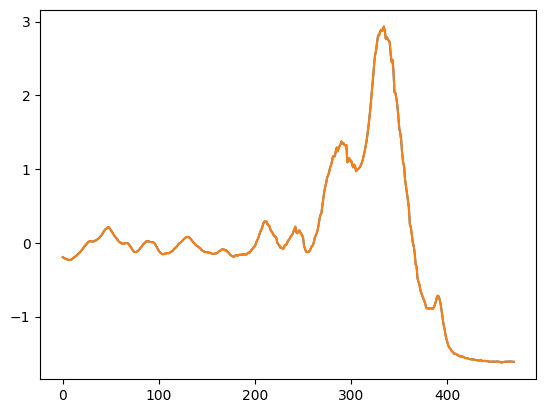

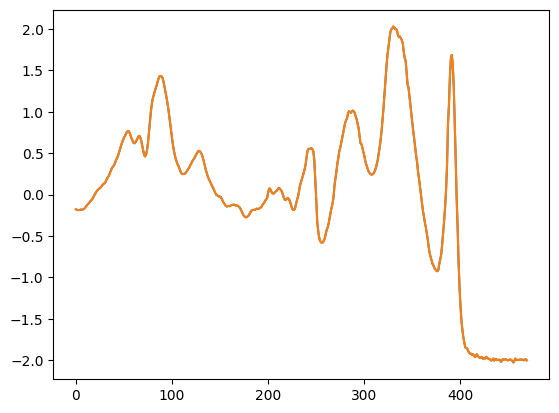

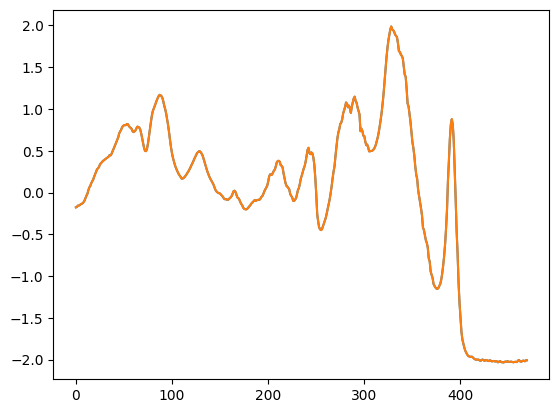

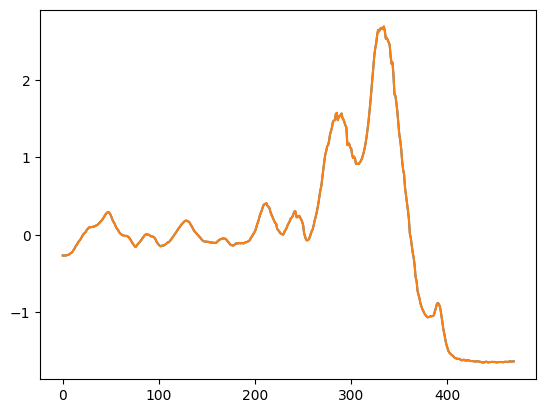

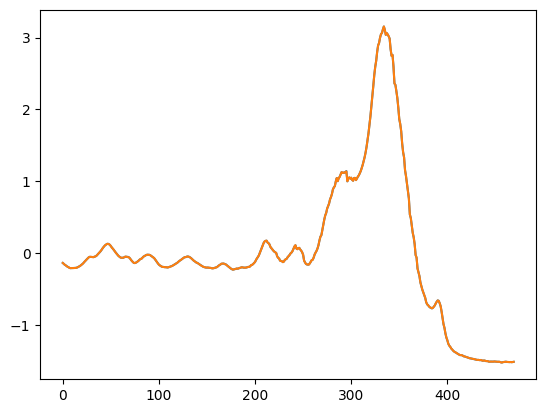

In [ ]:
import matplotlib.pyplot as plt

for i in range(30):
    plt.plot(x[i].reshape(-1, 1))
    plt.plot((r + x)[i].reshape(-1, 1))
    plt.show()

In [ ]:
r.shape

(30, 1, 470)

In [ ]:
# model.eval()

# epoch = 1000
# x_adv = []
# y_adv = []

# for x_test_tensor, _ in test_loader:

#     samples = x_test_tensor.to(device)
#     labels = model(samples).argmax(-1)
#     batch_size = len(samples)

#     r = torch.zeros_like(samples)
#     overshoot = 0.1
#     samples.requires_grad = True
#     r_ = torch.zeros_like(samples)
#     cri_ = list()
#     for i in range(epoch):
#         fs = model(samples+r)

#         _, pre = torch.max(fs, dim=-1)
#         criteria = (pre == labels).reshape(-1,1,1)
#         cri_.append(criteria.reshape(-1).detach().cpu().numpy())


#         ws =  calculate_jacob(model,samples+r,unique_classes)

#         f_0 = select_label(fs,labels)
#         w_0 = select_label(ws,labels)

#         f = fs - f_0.unsqueeze(1)
#         w = ws - w_0.unsqueeze(1)

#         value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
#         value = torch.where(torch.isnan(value), torch.tensor(float('inf'), device=value.device), value)

#         _, hat_L = torch.min(value, -1)


#         delta = (
#             torch.abs(select_label(f,hat_L).reshape(-1,1,1))
#             * select_label(w,hat_L)
#             / (torch.norm(select_label(w,hat_L), p=2) ** 2)
#         )

#         r = r + (1 + overshoot) * delta * criteria
#         r = r.detach()


#     x_adv.append((samples+r).detach().cpu().numpy())
#     y_adv.append((torch.max(model(samples+r), dim=-1)[-1]).detach().cpu().numpy())

# x_adv = np.concatenate(x_adv, axis=0)
# y_adv = np.concatenate(y_adv, axis=0)

# y = y_test
# print("ASR:",sum(y_adv !=  y)/30)

# x = samples.detach().cpu().numpy()
# r_ = r.detach().cpu().numpy()
# print("Dist:",(r_**2).mean())

/home/obob/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
/home/obob/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


ASR: 0.5333333333333333
Dist: 3.4791606e-06


In [ ]:
# crit = np.stack(cri_,axis=0).astype(float)
# (crit[1:]- crit[:999]).mean(-1)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.03333333,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.03333333,  0.        ,  0.        ,
        0.        , -0.03333333,  0.        ,  0.        ,  0.        ,
        0.        , -0.03333333,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.03333333,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
# model.eval()
# # samples = x_test_tensor.clone().detach().to(device)
# # labels = model(samples).argmax(-1)
# epoch = 100

# samples = x_test_tensor.to(device)
# labels = model(samples).argmax(-1)
# batch_size = len(samples)

# r = torch.zeros_like(samples)
# overshoot = 0.1
# samples.requires_grad = True
# max_ = 0
# for i in range(epoch):
#     fs = model(samples+r)

#     _, pre = torch.max(fs, dim=-1)
#     criteria =(pre == labels).float()

#     ws =  calculate_jacob(model,samples+r,unique_classes)

#     f_0 = select_label(fs,labels) * criteria
#     w_0 = select_label(ws,labels)

#     f = (fs - f_0.unsqueeze(1))
#     w = ws - w_0.unsqueeze(1)

#     value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
#     value = torch.where(torch.isnan(value), torch.tensor(float('inf'), device=value.device), value)

#     _, hat_L = torch.min(value, -1)


#     delta = (
#         torch.abs(select_label(f,hat_L).reshape(-1,1,1))
#         * select_label(w,hat_L)
#         / (torch.norm(select_label(w,hat_L), p=2) ** 2)
#     )

#     # r = r + (1 + overshoot) * delta
#     r = r + (1 + overshoot) * delta
#     r = r.detach()

In [ ]:
# model.eval()
# samples = x_test_tensor.clone().detach().to(device)
# labels = model(samples).argmax(-1)

# batch_size = len(samples)
# correct = torch.tensor([True] * batch_size)
# target_labels = labels.clone().detach().to(device)
# curr_steps = 0

# r = torch.zeros_like(samples)
# overshoot = 0.1
# samples.requires_grad = True

# for i in range(100):
#     fs = model(samples+r)
#     _, pre = torch.max(fs, dim=-1)
#     criteria = pre == labels
#     ws =  calculate_jacob(model,samples+r)

#     f_0 = select_label(fs,labels)
#     w_0 = select_label(ws,labels)

#     f = fs - f_0.unsqueeze(1)
#     w = ws - w_0.unsqueeze(1)

#     value = torch.abs(f) / torch.norm(w, p=2, dim=-1).squeeze(-1)
#     value_no_nan = torch.where(torch.isnan(value), torch.tensor(float('inf'), device=value.device), value)
#     _, hat_L = torch.min(value_no_nan, -1)

#     delta = (
#         torch.abs(select_label(f,hat_L).reshape(-1,1,1))
#         * select_label(w,hat_L)
#         / (torch.norm(select_label(w,hat_L), p=2) ** 2)
#     )

#     r = r + (1 + overshoot) * delta * criteria.reshape(-1,1,1)
#     r = torch.clamp(r, min=-0.1, max=0.1).detach()